In [1]:
import os
import numpy as np  # 1.23.5
import pandas as pd  # 1.5.0
import seaborn as sns  # 0.12.0

from rdkit import Chem  # 2023.03.3
from rdkit.Chem import rdFingerprintGenerator

from sklearn.ensemble import RandomForestRegressor  # 1.2.2
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr  # 1.9.1
from lightgbm import LGBMRegressor  # 4.0.0

from tqdm.auto import tqdm

DATA_DIRECTORY_PATH = os.path.join((os.path.split(os.getcwd())[0]), "data")

# 1) Feature generation

##### 1a) Read data

In [2]:
# Read csv file.

df = pd.read_csv(os.path.join(DATA_DIRECTORY_PATH, "FIA49k.csv.gz"))
df.shape

(48986, 57)

##### 1b) Calculate fingerprints

In [3]:
# Generate Morgan fingerprints with RDKit.
# Hydrogen atoms are added before features are calculated after generating the mol objects from SMILES strings.

RADIUS = 3
FPSIZE = 2048

fingerprints = {}
for _, data in tqdm(df.iterrows()):
    mol = Chem.MolFromSmiles(data.la_smiles)
    mol = Chem.AddHs(mol)

    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS, fpSize=FPSIZE)
    fingerprints[data.Compound] = fpgen.GetFingerprintAsNumPy(mol)

0it [00:00, ?it/s]

In [4]:
# Formatting.

fingerprint_df = pd.DataFrame(fingerprints).T.astype("int32")
fingerprint_df.columns = [f"fp_bit_{i+1}" for i in range(FPSIZE)]
fingerprint_df = fingerprint_df.reset_index(drop=False, names="Compound")
fingerprint_df.shape

(48986, 2049)

In [5]:
# Save data to csv file.

fingerprint_df.to_csv("morgan_fp_fia49k.csv", index=False)

# 2) RandomForestRegressors

##### 2a) Load and prepare data

In [6]:
# Read csv files.

final_df = pd.read_csv("morgan_fp_fia49k.csv")
df2 = pd.read_csv(os.path.join(DATA_DIRECTORY_PATH, "FIA49k.csv.gz"))

final_df.shape, df2.shape

((48986, 2049), (48986, 57))

In [7]:
# Formatting.

final_df = final_df.merge(df2[["Compound", "set_assignment", "fia_gas-DSDBLYP", "fia_solv-DSDBLYP"]], on="Compound")
final_df.shape

(48986, 2052)

In [8]:
# Set up train, validation, and test data frames.

X_train = final_df.loc[final_df["set_assignment"] == "train"]
X_validate = final_df.loc[final_df["set_assignment"] == "validate"]
X_test = final_df.loc[final_df["set_assignment"] == "test"]

y_train_gas = X_train["fia_gas-DSDBLYP"]
y_train_solv = X_train["fia_solv-DSDBLYP"]

y_validate_gas = X_validate["fia_gas-DSDBLYP"]
y_validate_solv = X_validate["fia_solv-DSDBLYP"]

y_test_gas = X_test["fia_gas-DSDBLYP"]
y_test_solv = X_test["fia_solv-DSDBLYP"]

compounds_train = list(X_train["Compound"])
compounds_validate = list(X_validate["Compound"])
compounds_test = list(X_test["Compound"])

to_be_droped = [col for col in list(final_df.columns) if "fp_bit_" not in col]

In [9]:
# Drop all columns which are not feature columns. 

X_train = X_train.drop(to_be_droped, axis=1)
X_validate = X_validate.drop(to_be_droped, axis=1)
X_test = X_test.drop(to_be_droped, axis=1)

print("Data shapes:")
print("train:      ", X_train.shape, y_train_gas.shape, y_train_solv.shape)
print("validate:   ", X_validate.shape, y_validate_gas.shape, y_validate_solv.shape)
print("test:       ", X_test.shape, y_test_gas.shape, y_test_solv.shape)

Data shapes:
train:       (32333, 2048) (32333,) (32333,)
validate:    (7001, 2048) (7001,) (7001,)
test:        (6732, 2048) (6732,) (6732,)


##### 2b) FIA_gas model

In [10]:
# Train RandomForestRegressor with FIA_gas.

rf_gas = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    verbose=2
)

rf_gas.fit(X_train, y_train_gas)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished


RandomForestRegressor(n_jobs=-1, verbose=2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


MAE_gas: 32.174 kJ/mol
r2_gas: 0.66


<AxesSubplot: title={'center': 'Predicted FIA vs. DFT FIA'}, xlabel='FIA calculated by DFT [kJ/mol]', ylabel='FIA prediction [kJ/mol]'>

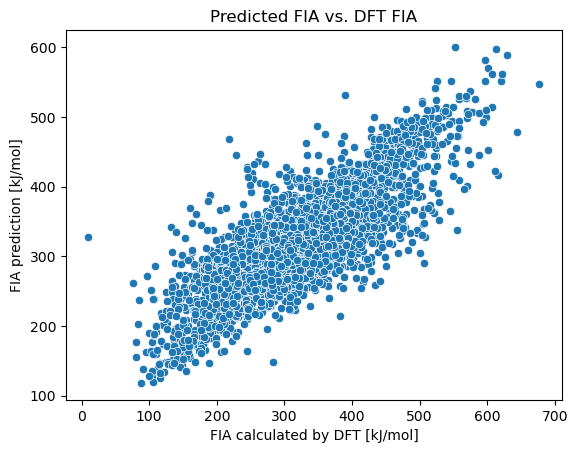

In [11]:
# Get and visualize prediction results.

predictions_gas = rf_gas.predict(X_test)

print(f"MAE_gas: {round(mean_absolute_error(y_test_gas, predictions_gas), 3)} kJ/mol")
print(f"r2_gas: {round(pearsonr(y_test_gas, predictions_gas)[0]**2, 4)}")

fig = sns.scatterplot(
    x=y_test_gas,
    y=predictions_gas
)

fig.set(xlabel="FIA calculated by DFT [kJ/mol]", ylabel="FIA prediction [kJ/mol]", title="Predicted FIA vs. DFT FIA")
fig

##### 2c) FIA_solv model

In [12]:
# Train RandomForestRegressor with FIA_solv.

rf_solv = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    verbose=2
)

rf_solv.fit(X_train, y_train_solv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished


RandomForestRegressor(n_jobs=-1, verbose=2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


MAE_solv: 29.675 kJ/mol
r2_solv: 0.6645


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot: title={'center': 'Predicted FIA vs. DFT FIA'}, xlabel='FIA calculated by DFT [kJ/mol]', ylabel='FIA prediction [kJ/mol]'>

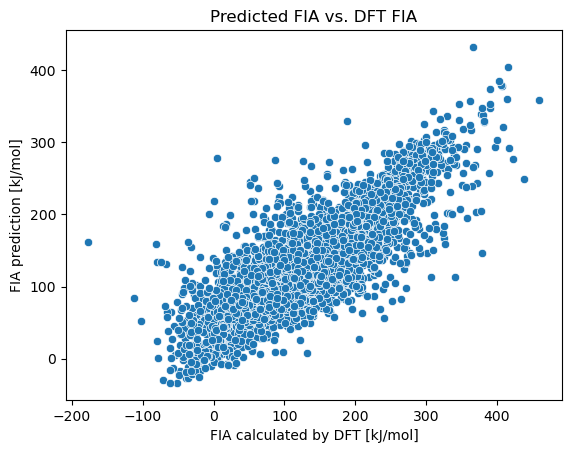

In [13]:
# Get and visualize prediction results.

predictions_solv = rf_solv.predict(X_test)

print(f"MAE_solv: {round(mean_absolute_error(y_test_solv, predictions_solv), 3)} kJ/mol")
print(f"r2_solv: {round(pearsonr(y_test_solv, predictions_solv)[0]**2, 4)}")

fig = sns.scatterplot(
    x=y_test_solv,
    y=predictions_solv
)

fig.set(xlabel="FIA calculated by DFT [kJ/mol]", ylabel="FIA prediction [kJ/mol]", title="Predicted FIA vs. DFT FIA")
fig

# 3) LGBMRegressor

##### 3a) Load and prepare data

In [ ]:
# Execute all cells given above under 2a).

##### 3b) FIA_gas model

In [14]:
# Train LGBMRegressor with FIA_gas.

lgbm_gas = LGBMRegressor(
    n_estimators=2000,
    early_stopping_round=15,
    verbose=2
)

lgbm_gas.fit(
    X_train, 
    y_train_gas,
    eval_set=[(X_validate, y_validate_gas)],
    eval_metric="r2"
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.977647
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.976431
[LightGBM] [Debug] init for col-wise cost 0.153261 seconds, init for row-wise cost 0.145459 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 32333, number of used features: 2048
[LightGBM] [Info] Start training from score 307.366296
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
Training until validation scores don't improve for 15 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] 

LGBMRegressor(early_stopping_round=15, n_estimators=2000, verbose=2)

MAE_gas: 28.292 kJ/mol
r2_gas: 0.7383


<AxesSubplot: title={'center': 'Predicted FIA vs. DFT FIA'}, xlabel='FIA calculated by DFT [kJ/mol]', ylabel='FIA prediction [kJ/mol]'>

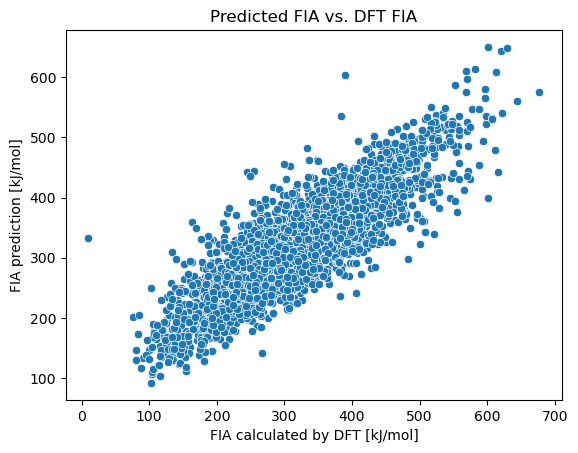

In [15]:
# Get and visualize prediction results.

predictions_gas = lgbm_gas.predict(X_test)

print(f"MAE_gas: {round(mean_absolute_error(y_test_gas, predictions_gas), 3)} kJ/mol")
print(f"r2_gas: {round(pearsonr(y_test_gas, predictions_gas)[0]**2, 4)}")

fig = sns.scatterplot(
    x=y_test_gas,
    y=predictions_gas
)

fig.set(xlabel="FIA calculated by DFT [kJ/mol]", ylabel="FIA prediction [kJ/mol]", title="Predicted FIA vs. DFT FIA")
fig

##### 3c) FIA_solv model

In [16]:
# Train LGBMRegressor with FIA_solv.

lgbm_solv = LGBMRegressor(
    n_estimators=2000,
    early_stopping_round=15,
    verbose=2
)

lgbm_solv.fit(
    X_train, 
    y_train_solv,
    eval_set=[(X_validate, y_validate_solv)],
    eval_metric="r2"
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.977647
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.976431
[LightGBM] [Debug] init for col-wise cost 0.130054 seconds, init for row-wise cost 0.162882 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 32333, number of used features: 2048
[LightGBM] [Info] Start training from score 122.153966
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
Training until validation scores don't improve for 15 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM]

LGBMRegressor(early_stopping_round=15, n_estimators=2000, verbose=2)

MAE_solv: 27.053 kJ/mol
r2_solv: 0.7283


<AxesSubplot: title={'center': 'Predicted FIA vs. DFT FIA'}, xlabel='FIA calculated by DFT [kJ/mol]', ylabel='FIA prediction [kJ/mol]'>

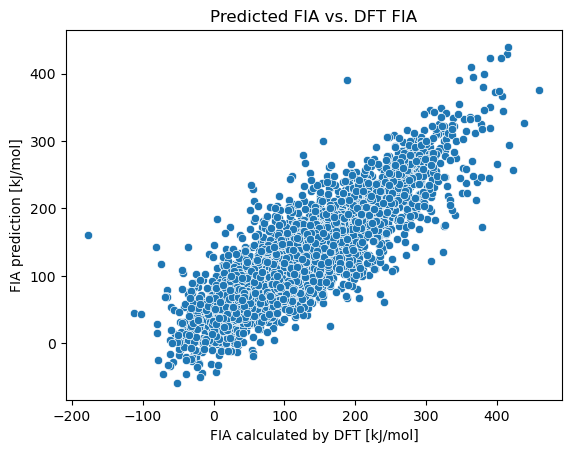

In [17]:
# Get and visualize prediction results.

predictions_solv = lgbm_solv.predict(X_test)

print(f"MAE_solv: {round(mean_absolute_error(y_test_solv, predictions_solv), 3)} kJ/mol")
print(f"r2_solv: {round(pearsonr(y_test_solv, predictions_solv)[0]**2, 4)}")

fig = sns.scatterplot(
    x=y_test_solv,
    y=predictions_solv
)

fig.set(xlabel="FIA calculated by DFT [kJ/mol]", ylabel="FIA prediction [kJ/mol]", title="Predicted FIA vs. DFT FIA")
fig